# Zoomcamp homework - week 1  
This notebook is about NYC taxi trip records of 2023 January and February trip records. 

## Import libraries

In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Import data

In [4]:
df_train = pd.read_parquet('../data/green_tripdata_2021-01.parquet')
len(df_train)

76518

In [5]:
#df_train = df_train.sample(frac=0.3, replace=True, random_state=1).reset_index()

In [6]:
col_1 = df_train.columns.to_list()

print(col_1)


['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge']


We can see that the column 'airport_fee' is diferent in both df, before merge it, we need to change it

In [7]:
target = ['duration']


In [9]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


## work 

In [11]:
#Convert to datetime
df_train['lpep_dropoff_datetime'] = pd.to_datetime(df_train['lpep_dropoff_datetime'])
df_train['lpep_pickup_datetime'] = pd.to_datetime(df_train['lpep_pickup_datetime'])

#Create duration column
df_train['duration'] = df_train['lpep_dropoff_datetime'] - df_train['lpep_pickup_datetime']
# Obtain only mins
df_train['duration'] = df_train['duration'].dt.total_seconds() / 60

### Q1 - Downloading the data

In [12]:
print(len(df_train.columns.to_list()))

21


### Q2. Computing duration

In [13]:
std_duration = df_train['duration'].std()
std_duration

59.33859413164492

### Q3. Dropping outliers

In [14]:
df_train['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

<Axes: >

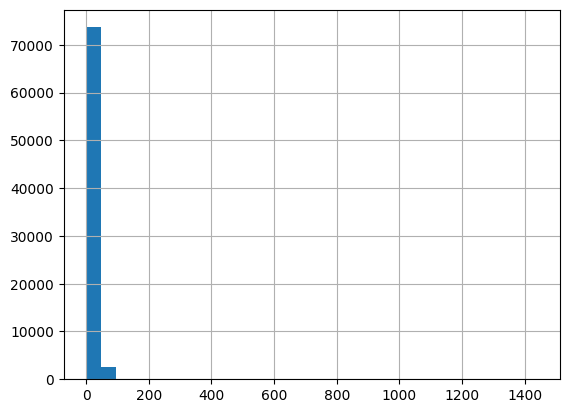

In [15]:
# Check the outliers 
df_train['duration'].hist(bins=30)

<Axes: >

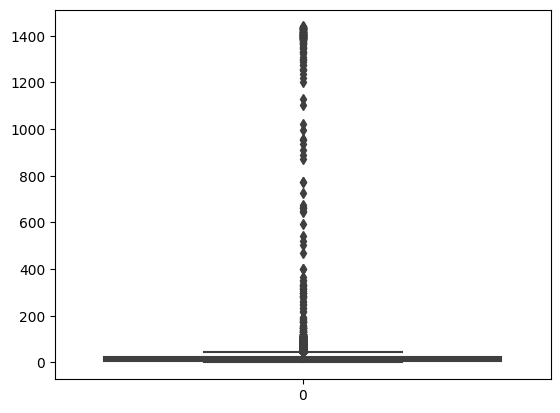

In [16]:
sns.boxplot(data = df_train['duration'])

This graffic show as that there are some outliers in this variable, let's get only values between 1-60 min 

In [17]:
len_before_outliers = len(df_train)

In [18]:
df_train = df_train[(df_train['duration'] >= 1) & (df_train['duration'] <= 60)]
len_after_outliers = len(df_train)

<Axes: >

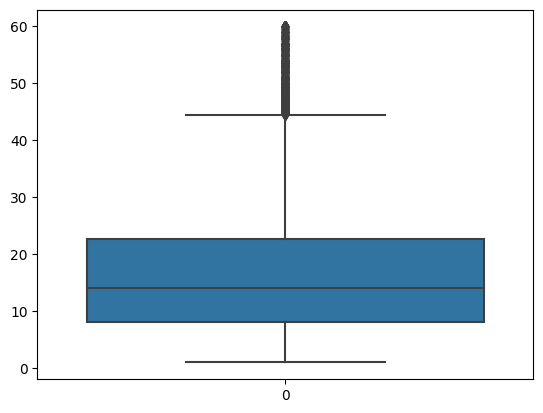

In [19]:
sns.boxplot(data = df_train['duration'])

Now we have a more explainable boxplot

In [20]:
print(f' len before drop outliers: {len_before_outliers}')
print(f' len before drop outliers: {len_after_outliers}')
print(f' outliers droped: {len_before_outliers - len_after_outliers}')
print(f' percentage droped respect start df: {(len_before_outliers - len_after_outliers) / len_before_outliers}')
print(f' percentage final respect start df: {(len_after_outliers) / len_before_outliers}')

 len before drop outliers: 76518
 len before drop outliers: 73908
 outliers droped: 2610
 percentage droped respect start df: 0.03410962126558457
 percentage final respect start df: 0.9658903787344154


### Q4. One-hot encoding

In [21]:
col_categorical = ['PULocationID', 'DOLocationID']
col_numerical = ['trip_distance']

df_train[col_categorical] = df_train[col_categorical].astype(str)

df_train = df_train[col_categorical + col_numerical + target]

C:\Users\mario.segura\AppData\Local\Temp\ipykernel_27172\2522102104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col_categorical] = df_train[col_categorical].astype(str)


In [22]:
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [23]:
encoded_features = enc.fit_transform(df_train[col_categorical])

# Create a new DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(encoded_features, columns=enc.get_feature_names_out(col_categorical))
print(f'The dimensionality of the one-hot matrix is: {len(one_hot_df.columns.to_list())}')

# Concatenate the one-hot encoded DataFrame with the remaining columns in df_train
df_train = pd.concat([df_train.drop(col_categorical, axis=1), one_hot_df], axis=1)

The dimensionality of the one-hot matrix is: 506


c:\Users\mario.segura\Anaconda3\envs\Mario\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
lenght_columns_train = len(df_train.columns.to_list())
print(f'the number of columns are: {lenght_columns_train - 2}')

the number of columns are: 506


In [25]:
df_train = df_train.dropna()

In [26]:
train_cols = df_train.columns.to_list()

### Q5. Training a model

In [27]:
y_train = df_train[target]
X_train = df_train.drop(columns = target)

In [28]:
X_train.head()

,trip_distance,PULocationID_10,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_106,PULocationID_107,PULocationID_108,PULocationID_11,PULocationID_112,...,DOLocationID_9,DOLocationID_90,DOLocationID_91,DOLocationID_92,DOLocationID_93,DOLocationID_94,DOLocationID_95,DOLocationID_96,DOLocationID_97,DOLocationID_98
0,1.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print(y_train.isna().sum())
print(X_train.isna().sum())

duration    0
dtype: int64
trip_distance       0
PULocationID_10     0
PULocationID_100    0
PULocationID_101    0
PULocationID_102    0
                   ..
DOLocationID_94     0
DOLocationID_95     0
DOLocationID_96     0
DOLocationID_97     0
DOLocationID_98     0
Length: 507, dtype: int64


In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)

In [31]:
mean_squared_error(y_train, y_pred_train, squared=False)

11.287525098571352

### test-validation

In [33]:
df_test = pd.read_parquet('../data/green_tripdata_2021-02.parquet')
len(df_test)
#df_test = df_test.sample(frac=0.3, replace=True, random_state=1).reset_index()

64572

In [34]:
col_2 = df_test.columns.to_list()
print(col_2)
df_test.rename(columns = {'Airport_fee' : 'airport_fee'}, inplace = True)

['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge']


In [35]:
#Convert to datetime
df_test['lpep_dropoff_datetime'] = pd.to_datetime(df_test['lpep_dropoff_datetime'])
df_test['lpep_pickup_datetime'] = pd.to_datetime(df_test['lpep_pickup_datetime'])

#Create duration column
df_test['duration'] = df_test['lpep_dropoff_datetime'] - df_test['lpep_pickup_datetime']
# Obtain only mins
df_test['duration'] = df_test['duration'].dt.total_seconds() / 60

In [36]:
df_test[col_categorical] = df_test[col_categorical].astype(str)

df_test = df_test[col_categorical + col_numerical + target]

In [37]:
encoded_features_test = enc.transform(df_test[col_categorical])

# Create a new DataFrame with the one-hot encoded columns
one_hot_df_test = pd.DataFrame(encoded_features_test, columns=enc.get_feature_names_out(col_categorical))

# Concatenate the one-hot encoded DataFrame with the remaining columns in df_train
df_test = pd.concat([df_test.drop(col_categorical, axis=1), one_hot_df_test], axis=1)

In [38]:
#df_test = df_test[train_cols]
y_test = df_test[target]
X_test = df_test.drop(columns = target)

In [39]:
y_pred_test = lr.predict(X_test)

In [40]:
mean_squared_error(y_test, y_pred_test, squared=False)

1232039.2669997977